# Simplify example observation with the agent

In [1]:
import sys
sys.path.append("../../")


from pathlib import Path

import keras
import numpy as np
import tensorflow as tf
import tensorflow_gnn as tfgnn
import tensorflow_gnn.proto.graph_schema_pb2 as schema_pb2
from google.protobuf import text_format

from zxreinforce.ZX_env import  ZXCalculus
from zxreinforce.rl_schemas import OBSERVATION_SCHEMA_ZX_final
from zxreinforce.Resetters import Resetter_ZERO_PI_PIHALF_ARB_hada
from zxreinforce.PPO_Agent_mult_GPU import PPOAgentPara
from zxreinforce.RL_Models import build_gnn_actor_model, build_gnn_critic_model
from zxreinforce.batch_utils import batch_mask_combined, batch_obs_combined_traj
from zxreinforce.plot_utils import plot_action

2023-11-30 13:27:46.714786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 13:27:47.706697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load agent
graph_schema = text_format.Merge(OBSERVATION_SCHEMA_ZX_final, schema_pb2.GraphSchema())
graph_tensor_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)

strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])


with strategy.scope():
    actor_model = build_gnn_actor_model(graph_tensor_spec=graph_tensor_spec)
    critic_model = build_gnn_critic_model(graph_tensor_spec=graph_tensor_spec)
    optimizer = keras.optimizers.Adam()

load_path_agent = Path("../../saved_agents/all_1/saved_agent")
load_idx = 400
ppo_agent = PPOAgentPara.load_from_folder(load_path_agent, actor_model, critic_model, optimizer, strategy, load_idx)

2023-11-30 13:27:51.571026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22793 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-11-30 13:27:51.572294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22793 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:86:00.0, compute capability: 7.5


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'piece_name' can't be nonlocal (__autograph_generated_fileo508qae4.py, line 18)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'piece_name' can't be nonlocal (__autograph_generated_fileo508qae4.py, line 18)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-11-30 13:27:53.565007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [1]
	 [[{{node Placeholder_1}}]]
2023-11-30 13:27:53.565102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [1]
	 [[{{node Placeholder_1}}]]
2023-11-30 13:27:53.687906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_3' with dtype int32 and shape [1]
	 [[{{node Plac

In [3]:
# Build env 
max_steps = 200
add_reward_per_step = 0
seed=0
count_down_from=20
dont_allow_stop=False


# Params for initial env observations
n_in_min=1
n_in_max=3
pi_fac=0.4
pi_half_fac=0.4
arb_fac=0.4
p_hada=0.2
min_mean_neighbours=2
max_mean_neighbours=4
fac = 1
min_spiders=10 * fac
max_spiders=15 * fac

# Resetter for inital observation
resetter = Resetter_ZERO_PI_PIHALF_ARB_hada(n_in_min,
                                    n_in_max,
                                    min_spiders,
                                    max_spiders,
                                    pi_fac,
                                    pi_half_fac,
                                    arb_fac,
                                    p_hada,
                                    min_mean_neighbours,
                                    max_mean_neighbours,
                                    np.random.default_rng(seed))


env = ZXCalculus(max_steps=max_steps, 
            add_reward_per_step=add_reward_per_step,
            resetter=resetter,
            check_consistencty=False,
            count_down_from=count_down_from,
            dont_allow_stop=dont_allow_stop)

/u/mnaegel/conda-envs/tf_gnn_4/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mask_list' of function 'batch_mask_np_jit'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../zxreinforce/batch_utils.py", line 193:
@numba.njit
def batch_mask_np_jit(mask_list:list)-> np.ndarray:
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


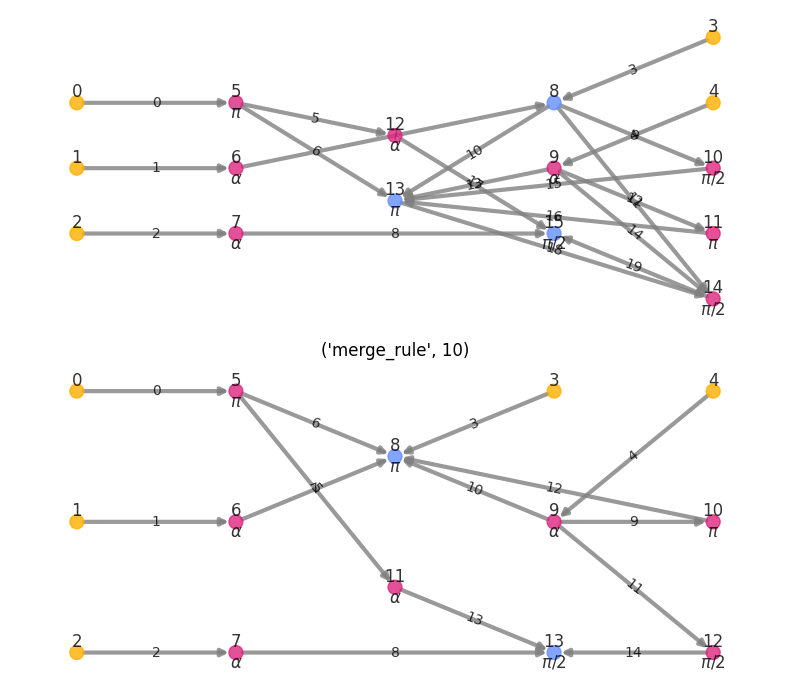

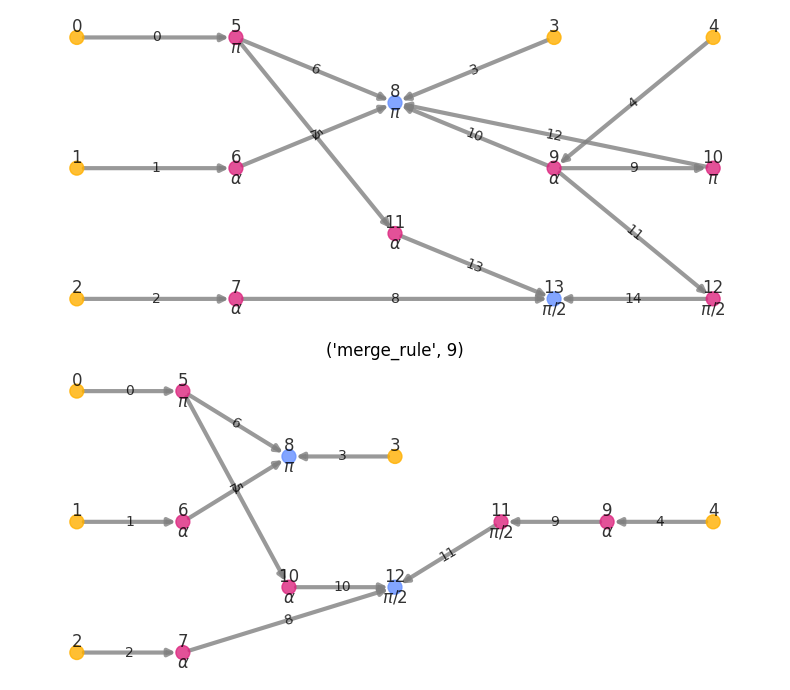

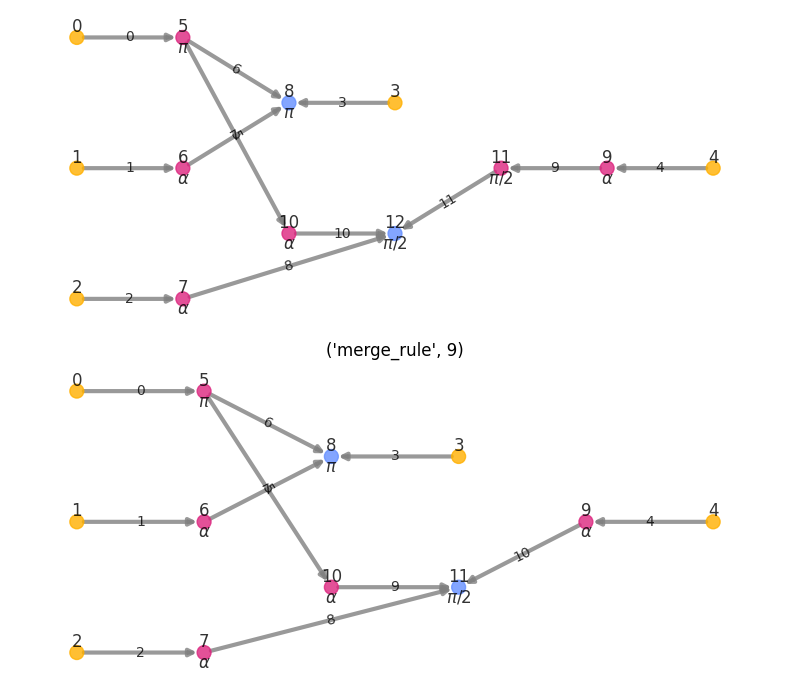

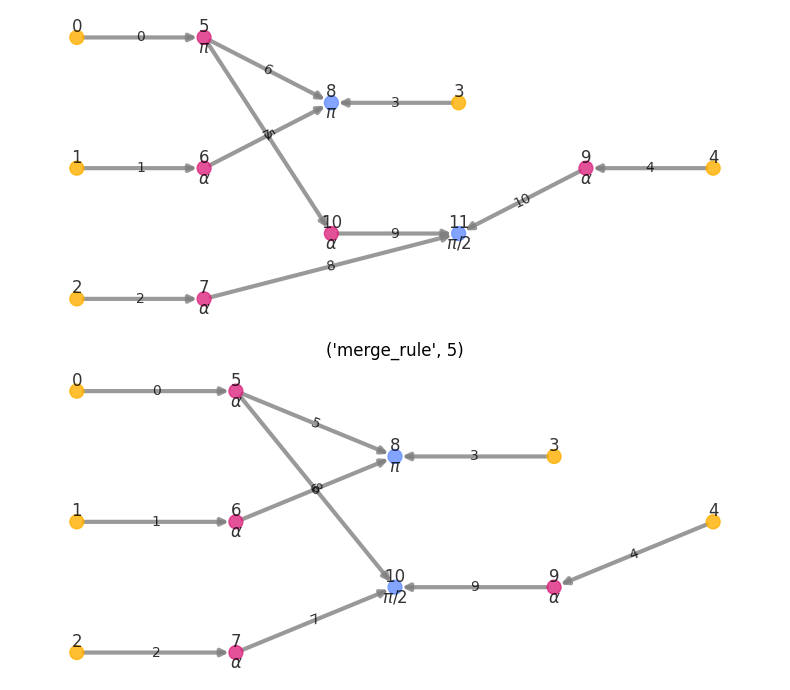

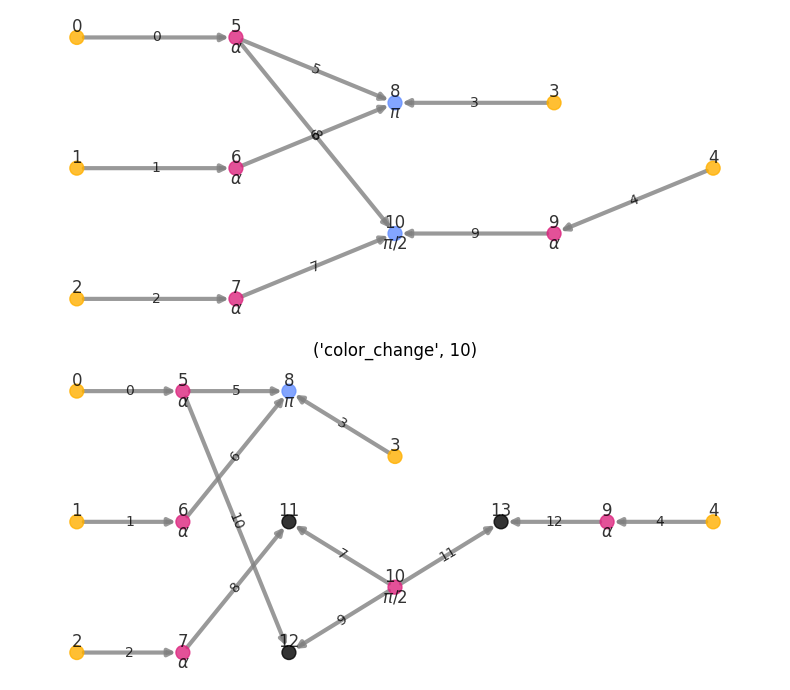

In [4]:
# Optimize for n_steps
n_steps = 5

observation, mask = env.reset()
observation = [observation]
mask = [mask]

for step in range(0, n_steps):

    # Batch graph observation to graph tensor and mask to tensor
    observation_batched = batch_obs_combined_traj(observation)
    mask_batched = batch_mask_combined(mask)
    # Get the logprobs, action
    action, logprobability_t  = ppo_agent.sample_action_logits_trajectory(observation_batched, mask_batched)
    # Take one step in the environment
    next_observation, next_mask, reward, next_done = env.step(action.numpy()[0])
    
    # Plot action
    plot_action(observation[0], next_observation, action.numpy()[0])
    
    observation = [next_observation]
    mask = [next_mask]
